#A conceptual model of the Saharan Climate-Vegetation system

In [2]:
#Load in the important modules for computation
%pylab inline
import numpy as np
import pylab as plt
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


**The equation set. Mainly taken from Lui 2010**  


$$\frac{d\nu}{dt}=\frac{\tanh(R)-\nu}{\tau_\nu}$$

$$R=1.3-180\ e\sin\tilde{\omega}+d\nu+N(t)$$

$$\frac{dN}{dt}=-\frac{N}{\tau_{\ _N}}+\frac{\sigma\varsigma(t)}{\tau_{\ _N}}$$

To redimensionalise $\nu$ back to V (vegetation fraction):

$$\nu=2\left(V-0.5\right)$$

To redimensionalise R (rainfall-ish) back to P (annual precip in mm/yr):
$$R=\frac{2}{D_c}\left(P-P_c\right)-0.5$$

**The required recipe**

1). Function to calculate orbital parameters from date  
2). Set some parameters [tauv in years]  
3). Create array to hold multiple runs of model (5000 x 10000 yrs)  
4). Create white noise array (5000x10000)  
5). Create samples of unknown variables [d,sigma,taun] (3x5000)  
6). Set initial V and N  
7). Build Function to move models on one timestep.  
8). Actually timestep through array  
*image: plot a couple of timeseries*  
9). Re-dimensionalise to give Precip and Veg Fraction  
10). Create function to detect collapse (perhaps identify stable or unstable collapse too)  
*image: plot this result on the sample timeseries from above*  
11). Average across the multiple array to get probabilities

##1. Calculate Orbital Parameters from date

At present, I plan the script to only work over Holocene. This means that I'll hardwire the parameters here and interpolate over them. Taking the hardwired values from Berger & Loutre (1991). The output will be precesssion (written with $e$ (the eccentricity) multiplied by sin $\tilde{\omega}$ (the omega value) above).

In [3]:
def PRECC(yearsBP=0.):
    '''
    This routine is given an age (in years BP) and returns the precession.
    '''
    eccen_BL91=[0.017236,0.017644,0.018024,0.018376,0.018697,0.018988,0.019249,0.019477,0.019674,0.019839,0.019971]
    omega_BL91=[101.37,84.26,67.23,50.3,33.45,16.68,359.99,343.37,326.82,310.32,293.86]
    age=np.linspace(0,-10000,11)
    preccs=eccen_BL91*np.sin(np.radians(omega_BL91))
    precc_func=interp1d(age, preccs)
    result=precc_func(yearsBP)
    return(result)

Check that this function is able to replicate Berger & Loutre (1991) with sufficient fidelity..


In [3]:
assert 0.01685 <= PRECC(0) < 0.01695
assert -0.0005 <= PRECC(-6000) <= 0.0005
assert -0.01826 <= PRECC(-9500) <= -0.01513

Write a little function to redimensionalise R ->  
$$P=P_c+0.5D_c(R+0.5)$$

In [4]:
def REDIM_PRECIP(nu=0.,N=0.,yearsBP=0.,bkgd_const=1.3,bkgd_precc=180.,d=0.,Dc=50.,Pc=300.):
    '''
    This routine is given the prognostic variables along an age
    (in years BP). It is also neccesary to parse in noise multiplication factore
    There is the possibility of altering the critical values
    '''
    r=bkgd_const-bkgd_precc*PRECC(k-10000)+d*nu+N
    P=Pc+0.5*Dc*(r+0.5)
    return(P)

##2. Define unvarying parameters

In [7]:
tauv=5. #timescale of vegetation memory in years (mentioned in passing in Lui 2010)
Dc=100. #Range of unstable rainfalls (Liu et al, 2006)
Pc=270. #Critical rainfall amount in mm/yr below whihc desert dominates (270 in Lui et al, 2006)

##3. Initialise the model instances

In [8]:
nu=np.ones((5000,10000))*999. #set the whole of the $\nu$ array to 999 as missing data
nu[:,0]=0. #set the initial conditions as 1 (forest)
N=np.ones((5000,10000))*999. #set the whole of the non-dim reainfall array to 999 as missing data
N[:,0]=1. #set the initial conditions of noise as 0

##4. Define the white noise and randomised parameter settings

In [16]:
noise=np.random.normal(0,1,(5000,10000)) #sample the noise from a gaussian dist with sigma=1 and mu=0
d=np.random.uniform(0.75,1.25,5000) #sample the noise multiplication factor in R equation. Ranges from 0->1 presently
sigma=np.random.uniform(0,2,5000) #sample the random noise factor (as set std dev to 1 above). Ranges from 0->1 presently
taun=np.random.uniform(0.3,3,5000)*tauv #sample the soil moisture timescale in years.
bkgd_const=np.random.uniform(0.8,1.7,5000)#sample non-Precc related background rainfall (1.3 from Brovkin)
bkgd_precc=np.random.uniform(80,280,5000)#sample Precc related background rainfall (180 from Brovkin)
print "Parameters settings are..." ,bkgd_const[3056],bkgd_precc[3056],d[3056] 

Parameters settings are... 1.08196217234 210.622338847 1.01998189005


##5. Create process to move forward one timestep.

In [17]:
#forward timestepping.
for k in range(1,9999):
#for k in range(1,10):
    if k%1000==0:
        print "We're on time %d" % (k-10000)
    r=bkgd_const-bkgd_precc*PRECC(k-10000)+d*nu[:,k]+N[:,k]
    #r=d*nu[:,k]+N[:,k]
    nu[:,k+1]=nu[:,k]+(np.tanh(r)-nu[:,k])/tauv
    N[:,k+1]=N[:,k]+(sigma*noise[:,k]-N[:,k])/taun #note. by choosing Dt=1, then the Dt and sqrt(Dt) disappear
    #print k,k-10000,r[0],np.tanh(r[0]),nu[0,k+1],nu[0,k],sigma[0]*noise[0,k],N[0,k+1],N[0,k]

We're on time -9000
We're on time -8000
We're on time -7000
We're on time -6000
We're on time -5000
We're on time -4000
We're on time -3000
We're on time -2000
We're on time -1000


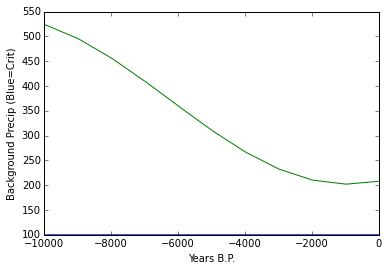

In [14]:
r=1.3-180*PRECC(range(-10000, -0))
P=Pc+0.5*Dc*(r+0.5)
plt.plot(range(-10000, -0),P,'g',range(-10000, -0),Dc*np.ones(10000),'b')
plt.xlabel('Years B.P.')
plt.ylabel('Background Precip (Blue=Crit)')
plt.show()

##6. Plot some example instances

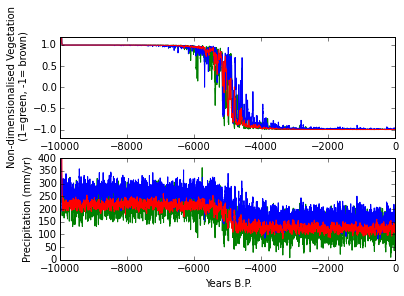

In [18]:
xaxis=range(-10000, -0)
plt.subplot(211)
plt.plot(xaxis,nu[3056,:],'g',xaxis,nu[2737,:],'b',xaxis,nu[4001,:],'r')
plt.xlabel(' ')
plt.ylabel('Non-dimensionalised Vegetation \n (1=green, -1= brown)')
plt.ylim(-1.2,1.2)
plt.subplot(212)
plt.plot(xaxis,REDIM_PRECIP(nu[3056,:],N[3056,:],xaxis,bkgd_const[3056],bkgd_precc[3056],d[3056],Dc,Pc),'g',
               xaxis,REDIM_PRECIP(nu[2737,:],N[2737,:],xaxis,bkgd_const[2737],bkgd_precc[2737],d[2737],Dc,Pc),'b',
               xaxis,REDIM_PRECIP(nu[4001,:],N[4001,:],xaxis,bkgd_const[4001],bkgd_precc[4001],d[4001],Dc,Pc),'r')
plt.xlabel('Years B.P.')
plt.ylabel('Precipitation (mm/yr)')
plt.ylim(0,400)
plt.show()

##7. Create a version with lower time resolution for easier plotting

[-0.99514793 -0.99529917 -0.87715802 -0.99954194 -0.98462283 -0.87333378
 -0.98774323 -0.99801094 -0.96643734 -0.99906404 -0.99944534 -0.99319779]
[-0.99665114 -0.99761414 -0.87076605 -0.99912667 -0.98671599 -0.81745862
 -0.99369338 -0.99731344 -0.97479606 -0.99820831 -0.99940982 -0.9898972 ]


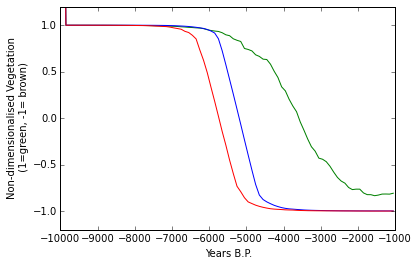

In [100]:
dates=np.arange(-9950,50,100)
nu_d=np.ones((5000,100))*999.
for d_index,d_val in enumerate(dates):
    #print d_index,d_val,10000+d_val-50,10000+d_val+49
    nu_d[:,d_index]=np.mean(nu[:,10000+d_val-50:1000+d_val+49],axis=1)
    

print nu_d[0:12,89]
print nu[0:12,9999]
plt.plot(dates,nu_d[3056,:],'g',dates,nu_d[2737,:],'b',dates,nu_d[4001,:],'r')
plt.xlabel('Years B.P.')
plt.ylabel('Non-dimensionalised Vegetation \n (1=green, -1= brown)')
plt.ylim(-1.2,1.2)
plt.show()

## 8. Calculate probability

[-9950 -9850 -9750 -9650 -9550 -9450 -9350 -9250 -9150 -9050 -8950 -8850]
[-9950 -9850 -9750 -9650 -9550 -9450 -9350 -9250 -9150 -9050 -8950 -8850]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


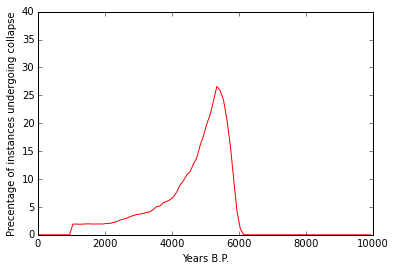

In [104]:
print dates[0:12]
prob_collapse=np.ones(100)*999.
for d_index,d_val in enumerate(dates):
    hist,bin_edges=np.histogram(nu_d[:,d_index],bins=(-5.,-0.25,0.25,5), density=False)
    prob_collapse[d_index]=array(hist[1])*100/5000.


print dates[0:12]
print prob_collapse[0:12]
plt.plot(abs(dates),prob_collapse,'r')
plt.xlabel('Years B.P.')
plt.ylabel('Precentage of instances undergoing collapse')
plt.ylim(0,40)
plt.show()

##7. Hovmuller of Equilibrium Potential for a single instance

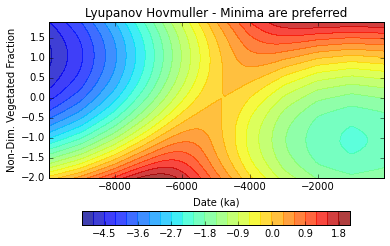

In [57]:
veg_frac_array=np.arange(-2,2,0.1)
surface=np.zeros((len(veg_frac_array),len(dates))) #set up the array
for d_index,d_val in enumerate(dates):
    surface[:,d_index]=veg_frac_array**2/2-np.log(np.cosh(bkgd_const[2819]-bkgd_precc[2819]*PRECC(d_val)+d[2819]*veg_frac_array))

plt.figure()
C=plt.contourf(dates,veg_frac_array,surface, 25, alpha=.75, cmap='jet')
plt.colorbar(C, orientation='horizontal', shrink=0.8)
plt.title('Lyupanov Hovmuller - Minima are preferred')
plt.ylabel('Non-Dim. Vegetated Fraction')
plt.xlabel('Date (ka)')
plt.show()

